In [1]:
import jax
import jax.numpy as jnp
import jax.random as jxr
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm

import sys
sys.path.append('../')
import utils
from models import wGPLDS, WeightSpaceGaussianProcess

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants
n_neurons = 10
latent_dim = 2
peaks = jnp.linspace(-jnp.pi, jnp.pi, n_neurons + 1)[:-1]  # tuning curve peaks
widths = 0.5 * jnp.ones(n_neurons)  # tuning curve widths
epsilon = 0.1
noise_scale = 0.1

In [3]:
@partial(jax.vmap, in_axes=(0, 0))
def dynamics(theta, omega):
    theta = (theta % (2 * jnp.pi)) - jnp.pi
    u = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    v = jnp.array([-jnp.sin(theta), jnp.cos(theta)])
    A = (1 - epsilon) * v[:, None] * v[None, :]
    b = u + omega * v
    z = jnp.clip(theta - peaks, -jnp.pi * widths, jnp.pi * widths)
    C = (1 + jnp.cos(z / widths))[:, None] * (
        jnp.tile(u[None, :], (n_neurons, 1))
    )
    return (A, b, C)

def initial_condition(theta, omega):
    m0 = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    S0 = noise_scale * jnp.eye(2)
    return (m0, S0)

def run_dynamics(key, As, bs, Cs, m0, S0):

    def f(x, inp):
        A, b, C, (subkey1, subkey2) = inp
        emission_noise = noise_scale * (
            jxr.multivariate_normal(subkey2, jnp.zeros(n_neurons), jnp.eye(n_neurons))
        )
        y = C @ x + emission_noise

        dynamics_noise = noise_scale * (
            jxr.multivariate_normal(subkey1, jnp.zeros(2), jnp.eye(2))
        )
        x_next = A @ x + b + dynamics_noise
        return x_next, (x_next, y)

    x_init = jxr.multivariate_normal(key, m0, S0)
    subkeys = jxr.split(key, num=(As.shape[0],2))
    _, (x_nexts, ys) = jax.lax.scan(f, x_init, xs=(As, bs, Cs, subkeys))
    # print(x_init)
    # print(x_nexts[0])
    xs = jnp.concatenate([x_init[None, :], x_nexts[:-1]], axis=0)
    return xs, ys

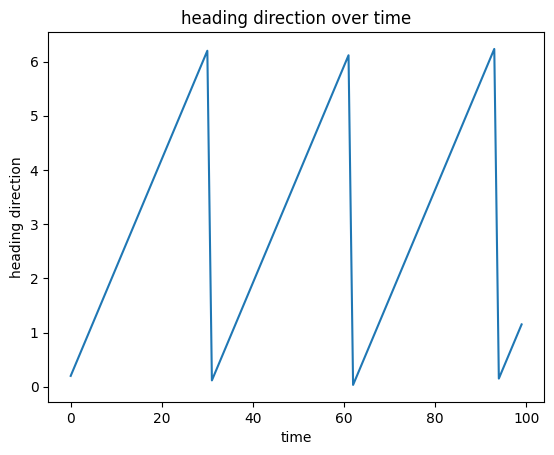

In [4]:
# Sample heading direction with constant velocity
num_timesteps = 100
speed = 0.2
omega = jnp.ones(num_timesteps) * speed
theta = jnp.cumsum(omega)

# Plot heading direction trajectory
plt.plot(theta % (2 * jnp.pi))
plt.ylabel('heading direction')
plt.xlabel('time')
plt.title('heading direction over time');

Text(0.5, 0.98, 'True params')

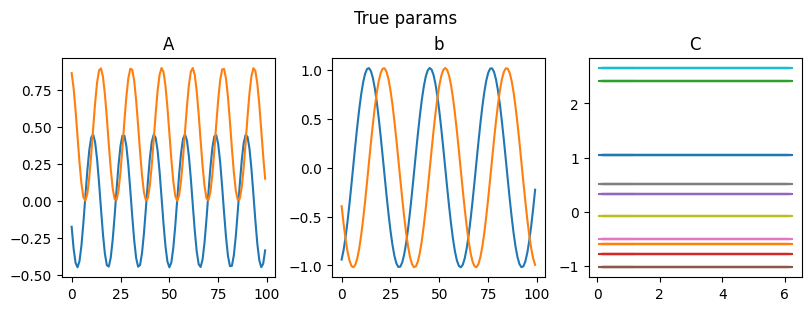

In [5]:
# Generate time-varying linear dynamics and initial condition

true_As, true_bs, true_Cs = dynamics(theta, omega)
# true_bs = jnp.ones((num_timesteps, 2))
# true_Cs = jnp.tile(jnp.eye(2), (num_timesteps, 1, 1))
true_C = jxr.normal(jxr.PRNGKey(0), (n_neurons, 2))
true_Cs = jnp.tile(true_C, (num_timesteps, 1, 1))
true_m0, true_S0 = initial_condition(theta[0], omega[0])

# Run the dynamics to get a batch of data

B = 100
X, Y = jax.vmap(
    lambda i: run_dynamics(jxr.PRNGKey(i), true_As, true_bs, true_Cs, true_m0, true_S0)
    )(jnp.arange(B))

partition = int(0.8 * B)
X_train, Y_train = X[:partition], Y[:partition]
X_test, Y_test = X[partition:], Y[partition:]

# Plot
fig, axs = plt.subplots(ncols=3, figsize=[8,3], constrained_layout=True)
axs[0].plot(true_As[:,1]);
axs[1].plot(true_bs);
axs[2].plot(theta % (2 * jnp.pi), true_Cs[:,:,0], '-');
axs[0].set_title("A")
axs[1].set_title("b")
axs[2].set_title("C")
fig.suptitle("True params")

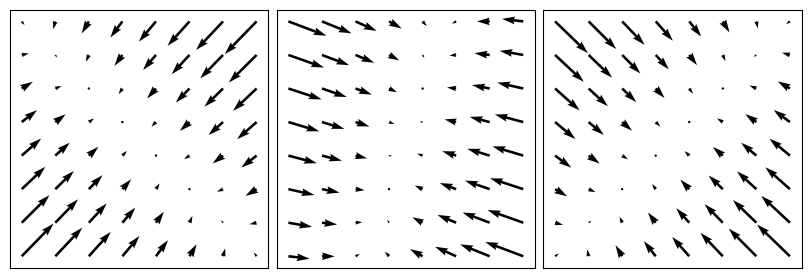

In [6]:
# Plot vector field given 2x2 matrix

def plot_vector_field(A, ax):
    x = jnp.linspace(-1, 1, 8)
    y = jnp.linspace(-1, 1, 8)
    X, Y = jnp.meshgrid(x, y)
    U = A[0, 0] * X + A[0, 1] * Y
    V = A[1, 0] * X + A[1, 1] * Y

    # Thicken the arrows
    ax.quiver(X, Y, U, V, units='width', scale=8, width=0.01)

fig, axs = plt.subplots(ncols=3, figsize=[8,3], constrained_layout=True)
plot_vector_field(true_As[3] - jnp.eye(latent_dim), axs[0])
axs[0].set_aspect('equal')

plot_vector_field(true_As[76] - jnp.eye(latent_dim), axs[1])
axs[1].set_aspect('equal')

plot_vector_field(true_As[58] - jnp.eye(latent_dim), axs[2])
axs[2].set_aspect('equal')

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig("figures/demo_HD_vector_field.eps", format='eps')

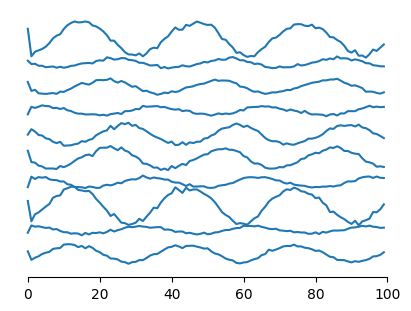

In [7]:
import seaborn as sns
fig, ax = plt.subplots(figsize=[4, 3], constrained_layout=True)
for i in range(n_neurons):
    ax.plot(Y[0][:,i] + 4*i, c='tab:blue')
sns.despine(ax=ax, trim=True, offset=True, left=True)
ax.set_yticks([])
# plt.savefig("figures/demo_HD_neurons.eps", format='eps')
plt.show()

In [8]:
jnp.argmin((theta % (2 * jnp.pi) - 7/4 * jnp.pi) % (2 * jnp.pi))

Array(58, dtype=int32)

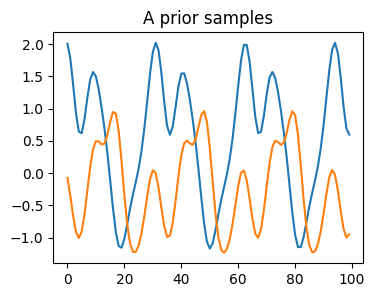

In [9]:
# Define model

_sigma, _kappa, _period = 0.5, 0.1, 2*jnp.pi
torus_basis_funcs = utils.T1_basis(5, _sigma, _kappa, _period)
constant_basis = [lambda x: jnp.ones_like(x)/_period]

A_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=latent_dim)
b_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=1)
C_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=n_neurons, D2=latent_dim)
model = wGPLDS(
    wgps={
        'A': A_prior, 
        'b': b_prior,
        'C': None,
        }, 
    state_dim=latent_dim, 
    emission_dim=n_neurons,
    )

fig, ax = plt.subplots(figsize=[4,3])
ax.plot(A_prior.sample(jxr.PRNGKey(0), theta)[:,0,0]);
ax.plot(A_prior.sample(jxr.PRNGKey(0), theta)[:,0,1]);
ax.set_title('A prior samples');

Iter 1/1000, log-prob = -991013.75, marginal log-lik = -994088.38
Iter 2/1000, log-prob = -14637.01, marginal log-lik = -17666.14
Iter 3/1000, log-prob = 16828.53, marginal log-lik = 13754.06
Iter 4/1000, log-prob = 25298.26, marginal log-lik = 22205.86
Iter 5/1000, log-prob = 27271.28, marginal log-lik = 24176.98
Iter 6/1000, log-prob = 28834.71, marginal log-lik = 25739.60
Iter 7/1000, log-prob = 30617.40, marginal log-lik = 27520.94
Iter 8/1000, log-prob = 32694.00, marginal log-lik = 29597.17
Iter 9/1000, log-prob = 35167.90, marginal log-lik = 32070.75
Iter 10/1000, log-prob = 37562.85, marginal log-lik = 34465.82
Iter 11/1000, log-prob = 39694.20, marginal log-lik = 36597.46
Iter 12/1000, log-prob = 41524.30, marginal log-lik = 38428.00
Iter 13/1000, log-prob = 43158.13, marginal log-lik = 40062.36
Iter 14/1000, log-prob = 44501.01, marginal log-lik = 41405.70
Iter 15/1000, log-prob = 45555.44, marginal log-lik = 42460.45
Iter 16/1000, log-prob = 46293.93, marginal log-lik = 4319

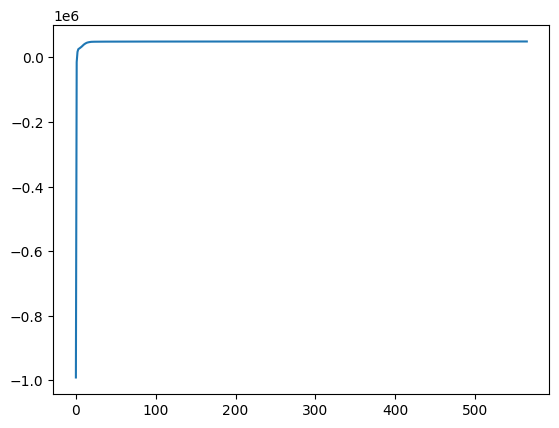

In [10]:
from models import ParamswGPLDS


seed = 0
A_key, b_key, C_key = jxr.split(jxr.PRNGKey(seed), 3)

conditions = theta

initial_params = ParamswGPLDS(
    dynamics_gp_weights = A_prior.weights(A_key),
    Q = 0.05 * jnp.eye(latent_dim),
    R = 0.05 * jnp.eye(n_neurons),
    m0 = jnp.zeros(latent_dim),
    S0 = jnp.eye(latent_dim),
    emissions_gp_weights = None,#C_prior.weights(C_key),
    bias_gp_weights=b_prior.weights(A_key),
    Cs = jnp.tile(jxr.normal(C_key, (n_neurons, 2)), (num_timesteps, 1, 1)),
    bs = None,# b_prior.sample(b_key, conditions).squeeze(),
)
thetas_train = jnp.tile(conditions, (B, 1))[:partition]
params, log_probs = model.fit_em(initial_params, emissions=Y_train, inputs=thetas_train, num_iters=1000)

if params.bs is None:
    params = params._replace(bs = b_prior(params.bias_gp_weights, conditions).squeeze())
if params.Cs is None:
    params = params._replace(Cs = C_prior(params.emissions_gp_weights, conditions))
if params.Cs.ndim == 2:
    params = params._replace(Cs=jnp.tile(params.Cs[None, :, :], (num_timesteps, 1, 1)))

plt.plot(log_probs)

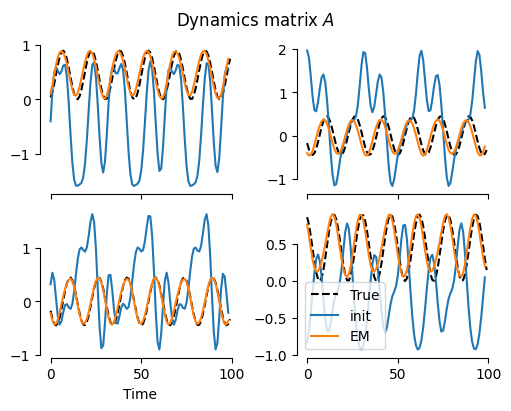

In [11]:
fig, axs = plt.subplots(ncols=latent_dim, nrows=latent_dim, figsize=(5, 4), constrained_layout=True);

for i in range(2):
    for j in range(2):
        ax = axs[i,j]
        ax.plot(true_As[:,i,j], 'k--', label='True')
        ax.plot(A_prior(initial_params.dynamics_gp_weights, theta[:-1])[:,i,j], label='init')
        ax.plot(A_prior(params.dynamics_gp_weights, theta[:-1])[:,i,j], label='EM')
        # ax.set_title(f'A[{i},{j}]')
axs[1,0].set_xlabel('Time')
axs[1,1].legend()

for ax in axs.flatten():
    sns.despine(ax=ax, trim=True, offset=True)
for ax in axs[0]:
    ax.set_xticklabels([])
    
fig.suptitle('Dynamics matrix $A$');

Text(0.5, 0, 'Time')

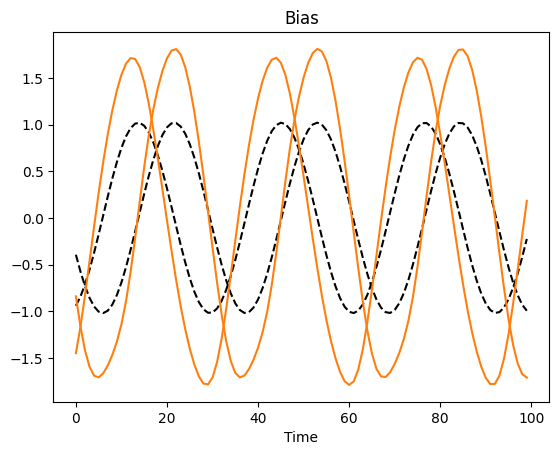

In [12]:
fig, ax = plt.subplots()
ax.plot(true_bs,'k--', label='True');
ax.plot(b_prior(params.bias_gp_weights, theta).squeeze(), c='tab:orange', label='EM');
ax.set_title("Bias")
ax.set_xlabel('Time')

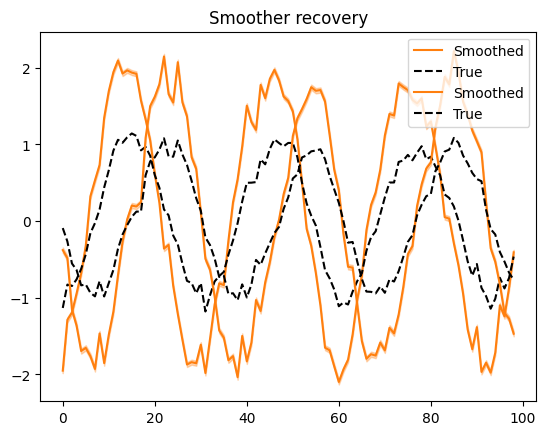

In [13]:
_, (filtered_means, _), (smoothed_means, smoothed_covs, _) = model.smoother(
    params, 
    emissions = Y_train[0],
    inputs = theta,
)

fig, ax = plt.subplots()
for i in range(2):
    ax.plot(smoothed_means[1:, i], color='tab:orange', label='Smoothed')
    ax.fill_between(
        jnp.arange(num_timesteps - 1),
        smoothed_means[1:, i] - 2 * jnp.sqrt(smoothed_covs[1:, i, i]),
        smoothed_means[1:, i] + 2 * jnp.sqrt(smoothed_covs[1:, i, i]),
        color='tab:orange',
        alpha=0.3,
    )
    ax.plot(X_train[0, 1:, i], 'k--', label='True')
ax.set_title('Smoother recovery')
ax.legend();

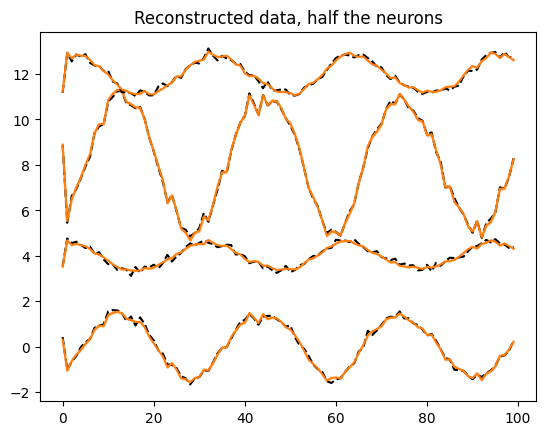

In [14]:
if params.Cs.ndim == 2:
    params = params._replace(Cs = jnp.tile(params.Cs[None, :], (num_timesteps, 1, 1)))

reconstructed_ys = jnp.einsum('tnl,tl->tn', params.Cs, smoothed_means)
reconstructed_ys_covs = jnp.einsum('tnl,tlk,tmk->tnm', params.Cs, smoothed_covs, params.Cs)

for neuron_id in range(n_neurons)[:4]:
    plt.plot(Y_train[0][:100,neuron_id]  + 4*neuron_id, c='k', ls='--');
    plt.plot(reconstructed_ys[:100,neuron_id] + 4*neuron_id, c='tab:orange');
    plt.fill_between(
        jnp.arange(len(reconstructed_ys))[:100],
        reconstructed_ys[:100,neuron_id] + 4*neuron_id - 2 * jnp.sqrt(reconstructed_ys_covs[:100,neuron_id,neuron_id]),
        reconstructed_ys[:100,neuron_id] + 4*neuron_id + 2 * jnp.sqrt(reconstructed_ys_covs[:100,neuron_id,neuron_id]),
        alpha=0.3, color='tab:orange',
    )

# plt.legend()
plt.title('Reconstructed data, half the neurons');

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


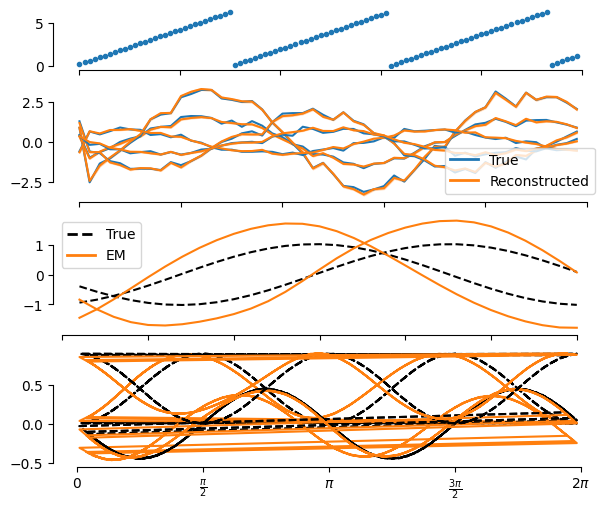

In [15]:
fig, axs = plt.subplots(nrows=4, figsize=(6, 5), height_ratios=[1,2,2,2], constrained_layout=True);

axs[0].plot(theta % (2 * jnp.pi), '.', c='tab:blue');

# Reconstruction

reconstructed_ys = jnp.einsum('tnl,tl->tn', params.Cs, smoothed_means)
reconstructed_ys_covs = jnp.einsum('tnl,tlk,tmk->tnm', params.Cs, smoothed_covs, params.Cs)

for neuron_id in range(n_neurons)[::2]:
    axs[1].plot(Y_train[0][:50,neuron_id], c='tab:blue');
    axs[1].plot(reconstructed_ys[:50,neuron_id], c='tab:orange');
    axs[1].fill_between(
        jnp.arange(len(reconstructed_ys))[:50],
        reconstructed_ys[:50,neuron_id] - 2 * jnp.sqrt(reconstructed_ys_covs[:50,neuron_id,neuron_id]),
        reconstructed_ys[:50,neuron_id] + 2 * jnp.sqrt(reconstructed_ys_covs[:50,neuron_id,neuron_id]),
        alpha=0.3, color='tab:orange',
    )

lines = [plt.Line2D([0], [0], color=c, linewidth=2, linestyle='-') for c in ['tab:blue', 'tab:orange']]
labels = ['True', 'Reconstructed']
axs[1].legend(lines, labels)

# Bias 

axs[2].plot(theta[:30] % (2*jnp.pi), true_bs[:30],'k--', label='True');
axs[2].plot(theta[:30] % (2*jnp.pi), params.bs[:30], c='tab:orange', label='EM');
# axs[1].set_title("Bias")
# axs[1].set_xlabel('Time')

# Dynamics

for i in range(2):
    for j in range(2):
        axs[3].plot(theta % (2*jnp.pi), true_As[:,i,j], 'k--', label='True')
        # axs[3].plot(A_prior(initial_params.dynamics_gp_weights, theta[:-1])[:,i,j], label='init')
        axs[3].plot(theta[:-1] % (2*jnp.pi), A_prior(params.dynamics_gp_weights, theta[:-1])[:,i,j], c='tab:orange', label='EM')
        # ax.set_title(f'A[{i},{j}]')

# Labels and formatting

for ax in axs[:-1]:
    ax.set_xticklabels([])
axs[-1].set_xticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi])
axs[-1].set_xticklabels(['0', r"$\frac{\pi}{2}$", '$\pi$', r"$\frac{3\pi}{2}$", '$2\pi$'])
for ax in axs.flatten():
    sns.despine(ax=ax, trim=True, offset=True)
# for ax in axs[0]:
#     ax.set_xticklabels([])


lines = [plt.Line2D([0], [0], color='k', linewidth=2, linestyle='--'), plt.Line2D([0], [0], color='tab:orange', linewidth=2, linestyle='-')]
labels = ['True', 'EM']
axs[2].legend(lines, labels)

plt.savefig("figures/demo_HD_EM_recovery.eps", format='eps')

0.2546479
0.9019723
1.7560567


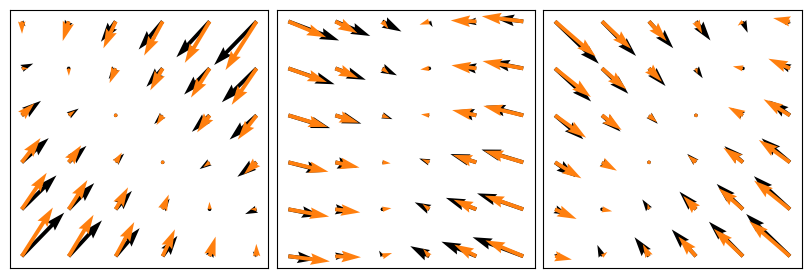

In [16]:
# Plot vector field given 2x2 matrix

def plot_vector_field(A, ax, color='k'):
    x = jnp.linspace(-1, 1, 6)
    y = jnp.linspace(-1, 1, 6)
    X, Y = jnp.meshgrid(x, y)
    U = A[0, 0] * X + A[0, 1] * Y
    V = A[1, 0] * X + A[1, 1] * Y

    # Thicken the arrows
    ax.quiver(X, Y, U, V, units='width', scale=6, width=0.015, color=color)

_As = A_prior(params.dynamics_gp_weights, theta[:-1])

fig, axs = plt.subplots(ncols=3, figsize=[8,3], constrained_layout=True)
plot_vector_field(true_As[3] - jnp.eye(latent_dim), axs[0])
plot_vector_field(_As[3] - jnp.eye(latent_dim), axs[0], color='tab:orange')
print(theta[3] % (2 * jnp.pi) / jnp.pi)

plot_vector_field(true_As[76] - jnp.eye(latent_dim), axs[1])
plot_vector_field(_As[76] - jnp.eye(latent_dim), axs[1], color='tab:orange')
print(theta[76] % (2 * jnp.pi) / jnp.pi)

plot_vector_field(true_As[58] - jnp.eye(latent_dim), axs[2])
plot_vector_field(_As[58] - jnp.eye(latent_dim), axs[2], color='tab:orange')
print(theta[58] % (2 * jnp.pi)  / jnp.pi)

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig("figures/demo_HD_vector_field_recovery.eps", format='eps')